# Song song thuật toán tính bao lồi trực giao

## 1.Ý tưởng song song hóa
- Các góc phần tư sẽ được tính toán một cách độc lập với nhau.
- Tại mỗi góc phần tư, tập dữ liệu sẽ được chia 2 nữa dựa trên lý thuyết của phương pháp tính bao lồi trực giao.
- Quá trình chia nữa này sẽ được thực hiện một cách đệ quy cho đến khi tập dữ liệu nhỏ hơn 1 kích thước cho trước, và sẽ được phân bổ cho 1 thread để đảm nhiệm quá trình tính toán bao lồi trực giao

## 2.Phương pháp hiện thực
- Thuật toán song song hóa được hiện thực bằng cách dùng multithreading của thư viện concurrent.futures
- Mỗi thread sẽ chỉ đảm nhận quá trình tính toán cho tập dữ liệu với kích thước nhỏ hơn hoặc bằng kích thước cho trước. Nếu tập dữ liệu lớn hơn kích thước quy định, tập dữ liệu đó sẽ được chia nhỏ ra làm đôi, và thực hiện quá trình tính toán bao lồi trực giao cho từng phần đó.

## 3.Cấu trúc chương trình
- find_extreme_points(points): hàm nhận tham số đầu vào là tập hợp điểm và trả về các điểm cực biên top, left, bottom, right. Nếu có nhiều hơn 1 điểm cực biên theo 1 hướng, thì kết quả trả về ở dạng mảng.
- find_o_hull(set, q, qq, quad): hàm tính toán bao lồi cho từng góc phần tư tùy thuộc vào tham số quad.
- findOCH(set, q, qq, quad): hàm chia đệ quy tập dữ liệu ban đầu, cho đến khi kích thước tập đó nhỏ hơn 1000 điểm thì dừng lại, và được phân chia cho 1 thread để thực hiện việc tính bao lồi trực giao bằng hàm find_o_hull
- findOrthogonalConvexHull_serial(points): thuật toán tìm bao lồi trực giao bằng phương pháp tuần tự.
- findOrthogonalConvexHull_multhr(points): thuật toán tìm bao lồi trực giao bằng phương pháp song song dùng multithreading

In [37]:
import matplotlib.pyplot as plt
import csv
import time
import concurrent.futures as cf
import pandas as pd

In [38]:
# Read input points.
input_points = []
dataset = []

chunksize = 10 ** 8
for chunk in pd.read_csv("./hollow_square/10000000.csv", chunksize=chunksize):
    input_points = chunk.values.tolist()

In [39]:
def find_extreme_points(points):
    maxY = points[0][1]
    minY = points[0][1]
    maxX = points[0][0]
    minX = points[0][0]
    
    leftPoints = []
    rightPoints = []
    topPoints = []
    bottomPoints = []
    
    for point in points:
        if point[0] < minX: minX = point[0] #leftmost point
        if point[0] > maxX: maxX = point[0] #rightmost point
        if point[1] < minY: minY = point[1] #lowest point
        if point[1] > maxY: maxY = point[1] #hightest point


    for point in points:
        if point[0] == minX: leftPoints.append(point) #add the points having minimal x-coordinate in lefPoints list
        if point[0] == maxX: rightPoints.append(point) #add the points having maxi mal x-coordinate in lefPoints list
        if point[1] == minY: bottomPoints.append(point) #add the points having minimal y-coordinate in lefPoints list
        if point[1] == maxY: topPoints.append(point) #add the points having maximal y-coordinate in lefPoints list

    # Sort the elements of the lists: topPoints, bottomPoints, rightPoints, and leftPoints and give the starting and ending points of each list

    if len(topPoints) == 1:
        top = (topPoints[0],)
    else:
        topPoints = sorted(topPoints, key = lambda x : x[0])
        top = (topPoints[0], topPoints[len(topPoints)-1])

    # bottom
    if len(bottomPoints) == 1:
        bottom = (bottomPoints[0],)
    else:
        bottomPoints = sorted(bottomPoints, key = lambda x : -x[0])
        bottom = (bottomPoints[0], bottomPoints[len(bottomPoints)-1])

    # right
    if len(rightPoints) == 1:
        right = (rightPoints[0],)
    else:
        rightPoints = sorted(rightPoints, key = lambda x : -x[1])
        right = (rightPoints[0], rightPoints[len(rightPoints)-1])

    # left
    if len(leftPoints) == 1:
        left = (leftPoints[0],)
    else:
        leftPoints = sorted(leftPoints, key = lambda x : x[1])
        left = (leftPoints[0], leftPoints[len(leftPoints)-1])

    return top,left,bottom,right

In [40]:
def partition(set, q, qq, quad):
    '''
    Tính bình phương khoảng cách từ điểm p tới đỉnh v(qq2[0], q2[1])
    '''
    def add(p):
        return (p[0] - qq[0])*(p[0] - qq[0]) + (p[1] - q[1])*(p[1] - q[1])
    '''
    Sắp xếp theo thứ tự giảm dần các khoảng cách từ p với v. New point là điểm đầu tiên trong dãy.    
    '''
    sort_set_Dist = sorted(set, key = add, reverse=True)

    '''
    max radius
    '''
    new_point = sort_set_Dist[0]
    
    new_set1 = []
    new_set2 = []

    if (quad == 1):
        for p in set:
            if p[0] > new_point[0]:
                new_set1.append(p)
            elif p[1] > new_point[1]:
                new_set2.append(p)
    elif quad == 2:
        for p in set:
            if p[0] < new_point[0]:
                new_set1.append(p)
            elif p[1] > new_point[1]:
                new_set2.append(p)
    elif quad == 3:
        for p in set:
            if p[0] < new_point[0]:
                new_set1.append(p)
            elif p[1] < new_point[1]:
                new_set2.append(p)
    elif quad == 4:
        for p in set:
            if p[0] > new_point[0]:
                new_set1.append(p)
            elif p[1] < new_point[1]:
                new_set2.append(p)
    return new_point, new_set1, new_set2

In [41]:
def find_o_hull(set, q, qq, quad):
    if len(set) == 0:
        if quad == 1 or quad == 3:
            return [qq]
        else:
            return [q]
    
    new_point, new_set1, new_set2 = partition(set, q, qq, quad)

    if quad == 1 or quad == 3:
        return [q] + find_o_hull(new_set1, q, new_point, quad) + find_o_hull(new_set2, new_point, qq, quad)
    else:
        return [qq] + find_o_hull(new_set2, new_point, qq, quad) + find_o_hull(new_set1, q, new_point, quad)

In [42]:
def findOCH(set, q, qq, quad):
    arranged_points = []
    if len(set) <= 1000:
        arranged_points = find_o_hull(set, q, qq, quad)
    else:
        new_point, new_set1, new_set2 = partition(set, q, qq, quad)
        quads = [quad, quad]
        results = []
        if quad == 1 or quad == 3:
            sets = [new_set1, new_set2]
            qs = [q, new_point]
            qqs = [new_point, qq]
        else:
            sets = [new_set2, new_set1]
            qs = [new_point, q]
            qqs = [qq, new_point]
            
        with cf.ThreadPoolExecutor(max_workers=2) as executor:
            results = executor.map(findOCH, sets, qs, qqs, quads)

            for result in results:
                arranged_points += result
    return arranged_points

In [43]:
def findOrthogonalConvexHull_serial(points):
    # Find 8 points
    top, left, bottom, right = find_extreme_points(points)
    if len(top) == 1:
        q1 = qq4 = top[0]
    else:
        q1 = top[0]
        qq4 = top[1]
    q4 = right[0]
    if len(right) == 1:
        qq3 = right[0]
    else:
        qq3 = right[1]
    q3 = bottom[0]
    if len(bottom) == 1:
        qq2 = bottom[0]
    else:
        qq2 = bottom[1]
    q2 = left[0]
    if len(left) == 1:
        qq1 = left[0]
    else:
        qq1 = left[1]

    # Separate to 4 sets of points
    set1 = []
    set2 = []
    set3 = []
    set4 = []
    
    for p in points:
        if p[0] < q1[0] and p[1] > qq1[1]:
            set1.append(p)
        if p[0] < qq2[0] and p[1] < q2[1]:
            set2.append(p)
        if p[0] > q3[0] and p[1] < qq3[1]:
            set3.append(p)
        if p[0] > qq4[0] and p[1] > q4[1]:
            set4.append(p) 

    arranged_points = []

    arranged_points = arranged_points + [q1] + find_o_hull(set1, qq1, q1, 2) + [qq1]
    arranged_points = arranged_points + [q2] + find_o_hull(set2, q2, qq2, 3) + [qq2]
    arranged_points = arranged_points + [q3] + find_o_hull(set3, qq3, q3, 4) + [qq3]
    arranged_points = arranged_points + [q4] + find_o_hull(set4, q4, qq4, 1) + [qq4]

    return arranged_points

In [44]:
def findOrthogonalConvexHull_multhr(points):
    # Find 8 points
    top, left, bottom, right = find_extreme_points(points)

    if len(top) == 1:
        q1 = qq4 = top[0]
    else:
        q1 = top[0]
        qq4 = top[1]
    q4 = right[0]
    if len(right) == 1:
        qq3 = right[0]
    else:
        qq3 = right[1]
    q3 = bottom[0]
    if len(bottom) == 1:
        qq2 = bottom[0]
    else:
        qq2 = bottom[1]
    q2 = left[0]
    if len(left) == 1:
        qq1 = left[0]
    else:
        qq1 = left[1]

    # Separate to 4 sets of points
    set1 = []
    set2 = []
    set3 = []
    set4 = []

    for p in points:
        if p[0] < q1[0] and p[1] > qq1[1]:
            set1.append(p)
        if p[0] < qq2[0] and p[1] < q2[1]:
            set2.append(p)
        if p[0] > q3[0] and p[1] < qq3[1]:
            set3.append(p)
        if p[0] > qq4[0] and p[1] > q4[1]:
            set4.append(p) 

    arranged_points = []
    sets = [set1, set2, set3, set4]
    qs = [qq1, q2, qq3, q4]
    qqs = [q1, qq2, q3, qq4]
    quads = [2, 3, 4, 1]

    with cf.ThreadPoolExecutor(max_workers=4) as executor:
        results = executor.map(findOCH, sets, qs, qqs, quads)

        for result in results:
            arranged_points += result

    return arranged_points

In [45]:
def findOrthogonalConvexHull_mulprc(points):
    # Find 8 points
    top, left, bottom, right = find_extreme_points(points)

    if len(top) == 1:
        q1 = qq4 = top[0]
    else:
        q1 = top[0]
        qq4 = top[1]
    q4 = right[0]
    if len(right) == 1:
        qq3 = right[0]
    else:
        qq3 = right[1]
    q3 = bottom[0]
    if len(bottom) == 1:
        qq2 = bottom[0]
    else:
        qq2 = bottom[1]
    q2 = left[0]
    if len(left) == 1:
        qq1 = left[0]
    else:
        qq1 = left[1]

    # Separate to 4 sets of points
    set1 = []
    set2 = []
    set3 = []
    set4 = []

    for p in points:
        if p[0] <= q1[0] and p[1] >= qq1[1]:
            set1.append(p)
        if p[0] <= qq2[0] and p[1] <= q2[1]:
            set2.append(p)
        if p[0] >= q3[0] and p[1] <= qq3[1]:
            set3.append(p)
        if p[0] >= qq4[0] and p[1] >= q4[1]:
            set4.append(p)

    arranged_points = []
    sets = [set1, set2, set3, set4]
    qs = [qq1, q2, qq3, q4]
    qqs = [q1, qq2, q3, qq4]
    quads = [2, 3, 4, 1]

    with cf.ProcessPoolExecutor(max_workers=5) as executor:
        results = executor.map(find_o_hull, sets, qs, qqs, quads)

        for result in results:
            arranged_points += result

    return arranged_points

In [46]:
def plotOCH(points):
    S = []
    n = len(points)
    for i in range(0, n-1):

        if points[i+1][0] > points[i][0] and points[i+1][1] > points[i][1]:
            
            p3 = [points[i][0], points[i+1][1]]
            
            S.append([i+1, p3])

        elif points[i+1][0] > points[i][0] and points[i+1][1] < points[i][1]:
            
            p3 = [points[i+1][0], points[i][1]]
            
            S.append([i+1, p3])

        elif points[i+1][0] < points[i][0] and points[i+1][1] < points[i][1]:

            p3 = [points[i][0], points[i+1][1]]

            S.append([i+1, p3])

        elif points[i+1][0] < points[i][0] and points[i+1][1] > points[i][1]:
            
            p3 = [points[i+1][0], points[i][1]]
            
            S.append([i+1, p3])
    
    for i in range(len(S)):
        points.insert(S[i][0]+i, S[i][1])
    points.append(points[0])
    ############################################################
    # Draw lines
    fig, ax = plt.subplots()

    # Input points in blue
    ax.plot([x[0] for x in input_points], [x[1] for x in input_points], 'r.')

    # Orthogonal convex hull points in red
    ax.plot([x[0] for x in points], [x[1] for x in points], 'b-')
    #ax.plot([list(points[0])[0], list(points[-1])[0]], [list(points[0])[1], list(points[-1])[1]],'r-')

    plt.ylabel('Y')
    plt.xlabel('X')
    plt.show()

### 3.1 Tìm bao lồi trực giao bằng phương pháp tuần tự

Algorithm running time: 4.9457 seconds.


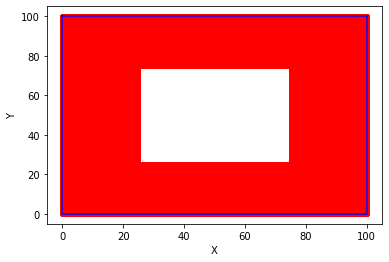

In [47]:
if __name__ == '__main__':
    '''
        SERIAL
    '''
    # Time measurement starts here
    start = time.perf_counter()
    # Find orthogonal points sequence (arranged to order)
    points = findOrthogonalConvexHull_serial(input_points)
    # Time measurement ends here
    finish = time.perf_counter()
    print(f"Algorithm running time: {round(finish - start, 5)} seconds.")

    ############################################################
    # plot the orthogonal hull
    plotOCH(points)

### 3.2 Tìm bao lồi trực giao bằng phương pháp song song dùng multithreading

Algorithm running time: 4.77571 seconds.


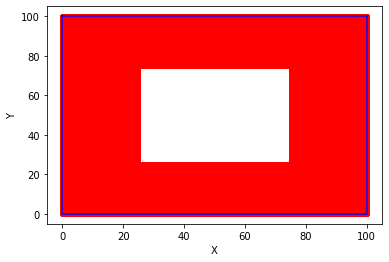

In [48]:
    '''
        MULTITHREADING
    '''
    # Time measurement starts here
    start = time.perf_counter()
    # Find orthogonal points sequence (arranged to order)
    points = findOrthogonalConvexHull_multhr(input_points)
    # Time measurement ends here
    finish = time.perf_counter()
    print(f"Algorithm running time: {round(finish - start, 5)} seconds.")

    ############################################################
    # plot the orthogonal hull
    plotOCH(points)

## 4.Kết quả

* Nghiệm của thuật toán song song hoàn toàn giống so với thuật toán tuần tự
* Kết quả thời gian tính toán cho một số tập dữ liệu cụ thể

Chia đệ quy (chia cho đến khi kích thích tập dữ liệu nhỏ hơn kích thước  hoặc bằng 1000 điểm)
| |Số điểm|Serial|Multithreading v2.0
| --- | --- | --- | ---
|disc|100|0.00018|0.01416
||1000|0.001615|0.00811
||10000|0.03552|0.06405
||100000|1.22623|1.57151
||1000000|16.22198|18.06811|
|hollow square|100|0.00014|0.00576
||1000|0.00129|0.0054
||10000|0.00575|0.01007
||100000|0.04856|0.05147
||<b>1000000</b>|<b>0.4728</b>|<b>0.46684</b>|
||<b>10000000</b>|<b>4.63405</b>|<b>4.5849</b>|
|hollow disc|100|0.00018|0.0202
||1000|0.00248|0.02986
||10000|0.0579|0.15493
||100000|1.86029|2.31425
||1000000|24.71042|26.38609|